# Studienarbeit ComputerVision 2
## Differences and Limitations of Unet and SegNet

---

In [11]:
# relevant imports
from torch import optim
from torchsummary import summary
from torchvision.transforms import transforms
from PIL import Image
from ray.air import session
from ray.train import Checkpoint
from torch.optim.lr_scheduler import OneCycleLR
from typing import List
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
from torchvision.datasets import Cityscapes
import torchvision.transforms.functional as F
from monai.networks.nets import UNet
from torch.utils.data import DataLoader
import os
import torch
import torch.nn as nn
import torchmetrics as TM
from tqdm import tqdm


#### Modelarchitecture
![unet_brain_mri.png](https://pytorch.org/assets/images/unet_brain_mri.png)

In [12]:
class UNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(UNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = UNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_2 = UNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_3 = UNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_4 = UNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottle_neck_block = UNet._conv_block(256, 512)

        # Decoder Blocks
        self.upconv_block_4 = UNet._upconv_block(512, 256)
        self.decoder_block_4 = UNet._conv_block(512, 256)

        self.upconv_block_3 = UNet._upconv_block(256, 128)
        self.decoder_block_3 = UNet._conv_block(256, 128)

        self.upconv_block_2 = UNet._upconv_block(128, 64)
        self.decoder_block_2 = UNet._conv_block(128, 64)

        self.upconv_block_1 = UNet._upconv_block(64, 32)
        self.decoder_block_1 = UNet._conv_block(64, 32)

        # Output convolution
        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e2 = self.encoder_block_2(self.max_pool_1(e1))
        e3 = self.encoder_block_3(self.max_pool_2(e2))
        e4 = self.encoder_block_4(self.max_pool_3(e3))

        b = self.bottle_neck_block(self.max_pool_4(e4))

        d4 = self.upconv_block_4(b)
        d4 = self.decoder_block_4(torch.cat((d4, e4), dim=1))
        d3 = self.upconv_block_3(d4)
        d3 = self.decoder_block_3(torch.cat((d3, e3), dim=1))
        d2 = self.upconv_block_2(d3)
        d2 = self.decoder_block_2(torch.cat((d2, e2), dim=1))
        d1 = self.upconv_block_1(d2)
        d1 = self.decoder_block_1(torch.cat((d1, e1), dim=1))

        return self.fc(d1)

    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

    @staticmethod
    def _upconv_block(input_size, output_size):
        return nn.ConvTranspose2d(input_size, output_size, kernel_size=2, stride=2)

In [6]:
# Load U-Net
unet = UNet(3, 1)
unet.cuda()
summary(unet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

---

#### Datapreparation

In [13]:
class SynchronizedCityscapes(Cityscapes):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __getitem__(self, index):
        image, mask = super().__getitem__(index)

        if torch.rand(1) < .5:
            image, mask = F.hflip(image), F.hflip(mask)

        return image, mask

In [14]:
transform_image = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

transform_mask = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor()])

train_dataset = SynchronizedCityscapes(root='~/res/datasets',
                           split='train',
                           mode='fine',
                           target_type='semantic',
                           transform=transform_image,
                           target_transform=transform_mask)

val_dataset = Cityscapes(root='~/res/datasets',
                         split='val',
                         mode='fine',
                         target_type='semantic',
                         transform=transform_image,
                         target_transform=transform_mask)


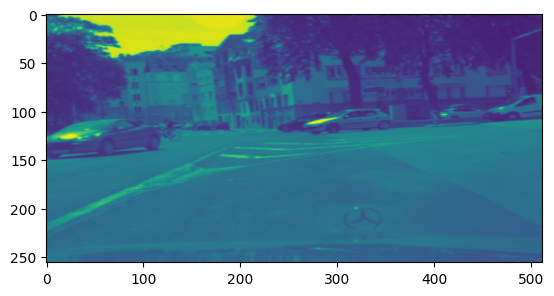

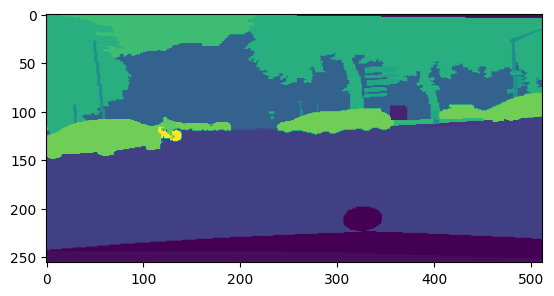

In [8]:
plt.imshow(train_dataset[0][0][0])
plt.show()
plt.imshow(train_dataset[0][1][0])

---

#### Training

In [5]:
def validation_loop(model: nn.Module, validation_dataloader: DataLoader, loss_fn, device) -> float:
    """
    Validation loop for the CNN
    :param model: neural network
    :param validation_dataloader: dataloader for the validation set
    :param loss_fn: loss function
    :param device: device on which to perform the validation
    :return: validation loss
    """
    running_val_loss: float = 0.
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            inputs, targets = vdata
            inputs, targets = inputs.to(device), targets.squeeze(1).long().to(device)

            vloss = loss_fn(model(inputs), targets)
            running_val_loss += vloss.item()
        running_val_loss /= (i + 1)

    return running_val_loss

In [6]:
def train_loop(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device) -> float:
    """
    Main minibatch train loop for the CNN
    :param model: neural network
    :param train_dataloader: dataloader for the train set
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param device: device on which to perform the training
    :return: train loss
    """
    running_tr_loss: float = 0.
    for i, data in enumerate(train_dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.squeeze(1).long().to(device)

        yhats = model(inputs)
        optimizer.zero_grad()
        tloss = loss_fn(yhats, targets)

        tloss.backward()
        optimizer.step()

        running_tr_loss += tloss.item()
    running_tr_loss /= (i + 1)

    return running_tr_loss

In [7]:
def train_unet(
        config: dict,
        train_dataset,
        validation_dataset,
        epochs: int,
        apply_scheduler: bool = True,
        return_flag: bool = False) -> dict | None:
    """
    Prepared train loop for ray parameter tuning.
    Training components:
        - model: CNN
        - loss function: CrossEntropyLoss
        - optimizer: Adam
        - scheduler: ExponentialLR (optional)

    :param config: dict of hyperparameters
    :param train_dataset:
    :param validation_dataset:
    :param epochs: number of epochs to train
    :param apply_scheduler: weather scheduler should be used or not
    :param return_flag: weather to return the model and losses or not
    :return: training results
    """

    device: torch.device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    print(device)
    model: nn.Module = UNet(3, 35).to(device)

    loss_fn = nn.CrossEntropyLoss()

    optim_params: dict = {
        'lr': config["lr"],
    }
    optimizer: optim.Adam = optim.Adam(model.parameters(), **optim_params)

    train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    validation_dataloader: DataLoader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)

    scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dataloader), epochs=epochs, pct_start=0.3)

    train_losses: List[float] = []
    val_losses: List[float] = []

    print('Start training...')
    for epoch in tqdm(range(epochs)):
        print('Start: ', epoch)
        model.train()

        # Train loop to iterate over the dataloader batches
        running_tr_loss: float = train_loop(model, train_dataloader, loss_fn, optimizer, device)
        if apply_scheduler:
            scheduler.step()

        # Validation loop
        running_val_loss: float = validation_loop(model, validation_dataloader, loss_fn, device)

        print(epoch, " - ", 'tr_loss:', running_tr_loss, 'val_loss:', running_val_loss)
        train_losses.append(running_tr_loss)
        val_losses.append(running_val_loss)

        # Save a checkpoint from the model
        os.makedirs("res/model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "res/model/checkpoint.pt")
        checkpoint: Checkpoint = Checkpoint.from_directory("res/model")
        session.report({"val_loss": running_val_loss,
                        "train_loss": running_tr_loss}, checkpoint=checkpoint)

    if return_flag:
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "model": model}

---

#### Training with parameter

In [ ]:
config = {'lr': 0.001}
res = train_unet(config, train_dataset, val_dataset, 50, return_flag=True, apply_scheduler=True)

cuda:5
Start training...


  0%|          | 0/50 [00:00<?, ?it/s]

Start:  0
0  -  tr_loss: 1.7972171078337 val_loss: 1.899221047759056


  2%|▏         | 1/50 [01:19<1:04:40, 79.19s/it]

Start:  1
1  -  tr_loss: 1.1327342505150653 val_loss: 1.156498208642006


  4%|▍         | 2/50 [02:37<1:03:08, 78.93s/it]

Start:  2
2  -  tr_loss: 0.9183786600194079 val_loss: 1.3299234509468079


  6%|▌         | 3/50 [03:57<1:02:03, 79.22s/it]

Start:  3
3  -  tr_loss: 0.8250292006959307 val_loss: 1.0146095231175423


  8%|▊         | 4/50 [05:16<1:00:31, 78.94s/it]

Start:  4
4  -  tr_loss: 0.7658040561574571 val_loss: 1.0898581221699715


 10%|█         | 5/50 [06:35<59:17, 79.05s/it]  

Start:  5
5  -  tr_loss: 0.7170169911486037 val_loss: 0.8985255286097527


 12%|█▏        | 6/50 [07:54<58:01, 79.11s/it]

Start:  6
6  -  tr_loss: 0.6827584302171747 val_loss: 0.8297778815031052


 14%|█▍        | 7/50 [09:13<56:40, 79.08s/it]

Start:  7
7  -  tr_loss: 0.6553984588765084 val_loss: 1.0380744487047195


 16%|█▌        | 8/50 [10:32<55:20, 79.07s/it]

Start:  8


In [9]:
val_losses = res['val_losses']
tr_losses = res['train_losses']
model = res['model']

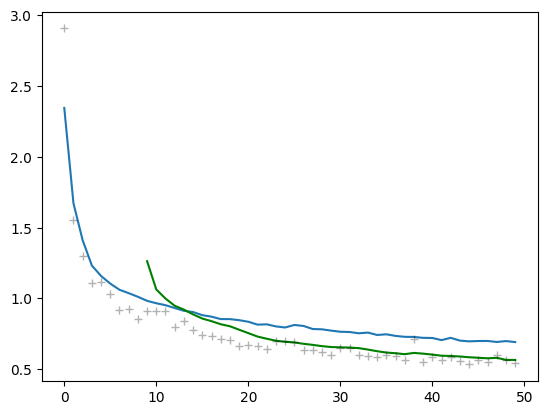

In [10]:
plt.plot(tr_losses)
plt.plot(pd.Series(val_losses).rolling(10).mean(), color='g')
plt.plot(val_losses, 'k+', alpha=0.3)
plt.show()

---

#### Evaluation

In [13]:
torch.save(model, '../../res/checkpoints/unet_cityscapes_full.pt')
torch.save(model.state_dict(), '../../res/checkpoints/unet_cityscapes.pt')

In [15]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [16]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
net = UNet(3, 35).to(device)

net = load_checkpoint(Path('../../res/checkpoints/unet_cityscapes.pt'), net)

In [19]:
def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, device) -> None:
    """
    Evaluate the pixel accuracy and the Intersection over Union (IoU) for the model
    :param model: neural network
    :param data_loader: torch DataLoader
    :param device: device on which to perform the evaluation
    :return: None
    """
    model.eval()

    iou_scores = []
    pixel_acc_scores = []
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            pred = nn.Softmax(dim=1)(outputs)
            pred = pred.argmax(dim=1)
            pred = pred.unsqueeze(1).long().to(device)

            iou = TM.classification.MulticlassJaccardIndex(35, average='macro').to(device)
            iou_score = iou(pred, targets)
            iou_scores.append(iou_score.item())

            pixel_metric = TM.classification.MulticlassAccuracy(35, average='macro').to(device)
            pixel_acc_score = pixel_metric(pred, targets)
            pixel_acc_scores.append(pixel_acc_score.item())

        iou_tensor = torch.FloatTensor(iou_scores)
        pixel_tensor = torch.FloatTensor(pixel_acc_scores)
        print(f"Iou: {iou_tensor.mean()}")
        print(f'Pixel Accuracy: {pixel_tensor.mean()}')


In [20]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
evaluate_model(net, test_dataloader, device)

100%|██████████| 8/8 [03:45<00:00, 28.23s/it]

Iou: 0.3693399131298065
Pixel Accuracy: 0.4465146064758301


In [17]:
def evaluate_iou_per_class(model: torch.nn.Module, data_loader: DataLoader, device, num_classes: int =35, ignore_index: int =255) -> torch.Tensor:
    """
    Evaluate the Intersection over Union (IoU) per class
    :param model: neural network
    :param data_loader: torch DataLoader
    :param device: device on which to perform the evaluation
    :param num_classes: amount of classifications the Dataset has
    :param ignore_index: index to be ignored in the evaluation like background
    :return: Tensor containing the IoU per class
    """
    model.eval()

    preds = []
    masks = []
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            pred = nn.Softmax(dim=1)(outputs)
            pred_labels = pred.argmax(dim=1)
            pred_labels = pred_labels.unsqueeze(1).long().to(device)

            preds.append(pred_labels)
            masks.append(targets)

    preds = torch.cat(preds, dim=0)
    masks = torch.cat(masks, dim=0)

    iou_metric = TM.classification.MulticlassJaccardIndex(num_classes=num_classes, average=None, ignore_index=ignore_index).to(device)
    iou_per_class = iou_metric(preds, masks)

    print(f"Class IoU: {iou_per_class}")
    return iou_per_class

In [18]:
evaluate_iou_per_class(net, test_dataloader, device)

100%|██████████| 8/8 [01:15<00:00,  9.41s/it]


Class IoU: tensor([0.0000, 0.9735, 0.9428, 0.9998, 0.1172, 0.0475, 0.0803, 0.9184, 0.6314,
        0.2126, 0.0408, 0.8136, 0.2227, 0.2717, 0.0000, 0.2098, 0.0000, 0.3635,
        0.0000, 0.2665, 0.4173, 0.8562, 0.4592, 0.8948, 0.5290, 0.2019, 0.8551,
        0.2422, 0.3230, 0.0000, 0.0000, 0.2610, 0.1396, 0.4824, 0.0000],
       device='cuda:6')


tensor([0.0000, 0.9735, 0.9428, 0.9998, 0.1172, 0.0475, 0.0803, 0.9184, 0.6314,
        0.2126, 0.0408, 0.8136, 0.2227, 0.2717, 0.0000, 0.2098, 0.0000, 0.3635,
        0.0000, 0.2665, 0.4173, 0.8562, 0.4592, 0.8948, 0.5290, 0.2019, 0.8551,
        0.2422, 0.3230, 0.0000, 0.0000, 0.2610, 0.1396, 0.4824, 0.0000],
       device='cuda:6')